In [1]:
import numpy as np
import torch
import tqdm
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from widis_lstm_tools.nn import LSTMLayer

# Prepare some random generators for later
rnd_gen = np.random.RandomState(seed=123)
_ = torch.manual_seed(123)

In [2]:
class Environment(Dataset):
    def __init__(self, n_samples: int, max_timestep: int, n_positions: int, rnd_gen: np.random.RandomState):
        """Our simple 1D environment as PyTorch Dataset"""
        super(Environment, self).__init__()
        n_actions = 2
        
        # C'est juste les règles du jeu et rien d'autre. Zéro position c'est la position de départ du joueur
        zero_position = int(np.ceil(n_positions / 2.))
        coin_position = zero_position + 2
        
        # Generate random action sequences. Génère une séquence d'action aléatoire de soit 0 ou 1.
        # Une ligne représente une séquence complète d'actions
        actions = np.asarray(rnd_gen.randint(low=0, high=2, size=(n_samples, max_timestep)), dtype=np.int)
            
        # Si l'agent a joué l'action 0 alors on prend l'identité, soit [1,0]
        # Si l'agent a joué l'action 1 alors on prend l'identité, soit [0,1]
        actions_onehot = np.identity(n_actions, dtype=np.float32)[actions]
        
        # Generate observations from action sequences
        # Ça permet de convertir une action 0 en -1 et l'action 1 reste là même. On va avoir une matrice de -1 et 1.
        # Ça permet de faire déplacer l'agent.
        actions[:] = (actions * 2) - 1
        
        # On génère 1000 samples dont la trajectoire est de 50 pas. Donc la simulation est de 50 steps au maximum
        observations = np.full(fill_value=zero_position, shape=(n_samples, max_timestep), dtype=np.int)
        
        print(observations.shape)
        
        # On prend toutes les actions au temps 1
        for t in range(max_timestep-1):
            action = actions[:, t]
            
            # Essentiellement ce que ça fait c'est que ça additionne les actions au observations et ça clip 
            # les observations entre 0 et la position n-1, c'est juste pour la simulation et pas pour notre problème. 
            observations[:, t+1] = np.clip(observations[:, t] + action, 0, n_positions-1)
            
        observations_onehot = np.identity(n_positions, dtype=np.float32)[observations]
        
        # On veut donc avoir ici la position du joueur
        print(np.identity(n_positions, dtype=np.float32))
        print(observations_onehot.shape)
        print(observations.shape)
        
        # Calculate rewards (sum over coin position for all timesteps)
        rewards = np.zeros(shape=(n_samples, max_timestep), dtype=np.float32)
        rewards[:, -1] = observations_onehot[:, :, coin_position].sum(axis=1)
        
        self.actions = actions_onehot
        self.observations = observations_onehot
        self.rewards = rewards
        
    def __len__(self):
        return self.rewards.shape[0]
    
    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx], self.rewards[idx]


n_positions = 13
env = Environment(n_samples=1000, max_timestep=50, n_positions=13, rnd_gen=rnd_gen)
env_loader = torch.utils.data.DataLoader(env, batch_size=8)

(1000, 50)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1000, 50, 13)
(1000, 50)


(50, 13) (50, 2) (50,)


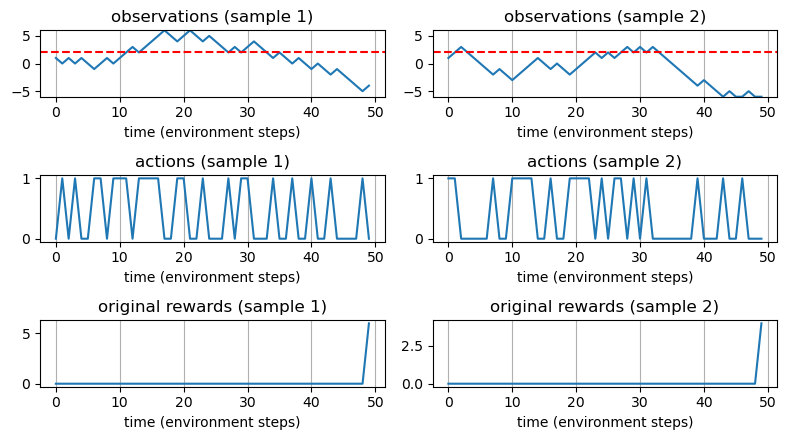

In [3]:
# obs0, a0 et r0 sont des séquences complètes. C'est l'historique d'une trajectoire !!
obs0, a0, r0 = env.__getitem__(3)
obs1, a1, r1 = env.__getitem__(25)

print(obs1.shape, a1.shape, r1.shape)

fig, axes = plt.subplots(3, 2, figsize=(8, 4.5), dpi=100)
axes[0, 0].plot(obs0.argmax(-1) - 6)
axes[0, 1].plot(obs1.argmax(-1) - 6)
axes[0, 0].set_ylim(-6, 6)
axes[0, 1].set_ylim(-6, 6)
axes[0, 0].axhline(2, linestyle='--', color='r')
axes[0, 1].axhline(2, linestyle='--', color='r')
axes[0, 0].xaxis.grid(True)
axes[0, 1].xaxis.grid(True)
axes[0, 0].set_title('observations (sample 1)')
axes[0, 1].set_title('observations (sample 2)')
axes[0, 0].set_xlabel('time (environment steps)')
axes[0, 1].set_xlabel('time (environment steps)')

axes[1, 0].plot(a0.argmax(-1))
axes[1, 1].plot(a1.argmax(-1))
axes[1, 0].xaxis.grid(True)
axes[1, 1].xaxis.grid(True)
axes[1, 0].set_title('actions (sample 1)')
axes[1, 1].set_title('actions (sample 2)')
axes[1, 0].set_xlabel('time (environment steps)')
axes[1, 1].set_xlabel('time (environment steps)')

axes[2, 0].plot(r0)
axes[2, 1].plot(r1)
axes[2, 0].xaxis.grid(True)
axes[2, 1].xaxis.grid(True)
axes[2, 0].set_title('original rewards (sample 1)')
axes[2, 1].set_title('original rewards (sample 2)')
axes[2, 0].set_xlabel('time (environment steps)')
axes[2, 1].set_xlabel('time (environment steps)')

fig.tight_layout()

In [4]:
class Net(torch.nn.Module):
    def __init__(self, n_positions, n_actions, n_lstm):
        super(Net, self).__init__()
        
        # This will create an LSTM layer where we will feed the concatenate
        self.lstm1 = LSTMLayer(
            in_features=n_positions+n_actions, out_features=n_lstm, inputformat='NLC',
            # cell input: initialize weights to forward inputs with xavier, disable connections to recurrent inputs
            w_ci=(torch.nn.init.xavier_normal_, False),
            # input gate: disable connections to forward inputs, initialize weights to recurrent inputs with xavier
            w_ig=(False, torch.nn.init.xavier_normal_),
            # output gate: disable all connection (=no forget gate) and disable bias
            w_og=False, b_og=False,
            # forget gate: disable all connection (=no forget gate) and disable bias
            w_fg=False, b_fg=False,
            # LSTM output activation is set to identity function
            a_out=lambda x: x
        )
        
        # After the LSTM layer, we add a fully connected output layer
        self.fc_out = torch.nn.Linear(n_lstm, 1)
    
    def forward(self, observations, actions):
        # Process input sequence by LSTM
        lstm_out, *_ = self.lstm1(torch.cat([observations, actions], dim=-1),
                                  return_all_seq_pos=True  # return predictions for all sequence positions
                                  )
        net_out = self.fc_out(lstm_out)
        print(net_out.shape)
        return net_out


# Create Network
device = 'cuda:0'
net = Net(n_positions=n_positions, n_actions=2, n_lstm=16)
_ = net.to(device)

In [9]:
def lossfunction(predictions, rewards):
    returns = rewards.sum(dim=1)
    
    # Main task: predicting return at last timestep. 
    # Essentiellement c'est le calcul de MSE
    main_loss = torch.mean(predictions[:, -1] - returns) ** 2
    
    # Auxiliary task: predicting final return at every timestep ([..., None] is for correct broadcasting)
    # Prediction détient une dimension de plus alors il ajoute une dimensions avec returns[..., None]
    # Ça revient à faire returns[:, None] en une dimension
    aux_loss = torch.mean(predictions[:, :] - returns[..., None]) ** 2
    # Combine losses
    # C'est nébuleux pour moi cette loss
    loss = main_loss + aux_loss * 0.5
    return loss

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
for name, i in net.named_parameters():    
    print(name)
update = 0
n_updates = 5000
running_loss = 100.
progressbar = tqdm.tqdm(total=n_updates)
while update < n_updates:
    for data in env_loader:
        # Get samples
        observations, actions, rewards = data
        observations, actions, rewards = observations.to(device), actions.to(device), rewards.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Get outputs for network
        outputs = net(observations=observations, actions=actions)
        
        
        # Calculate loss, do backward pass, and update
        loss = lossfunction(outputs[..., 0], rewards)
        loss.backward()
        running_loss = running_loss*0.99 + loss*0.01
        optimizer.step()
        update += 1
        progressbar.set_description(f"Loss: {running_loss:8.4f}")
        progressbar.update(1)

progressbar.close()




  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]


Loss:  99.0054:   0%|                                                                         | 0/5000 [00:00<?, ?it/s]


Loss:  98.0157:   0%|                                                                 | 1/5000 [00:00<04:19, 19.23it/s]


Loss:  97.0407:   0%|                                                                 | 2/5000 [00:00<03:12, 25.97it/s]


Loss:  96.0724:   0%|                                                                 | 3/5000 [00:00<02:49, 29.41it/s]


Loss:  96.0724:   0%|                                                                 | 4/5000 [00:00<02:08, 38.83it/s]


Loss:  95.1216:   0%|                                                                 | 4/5000 [00:00<02:08, 38.83it/s]


Loss:  94.1799:   0%|                                                                 | 5/5000 [00:00<02:08, 38.83it/s]

lstm1.c_first
lstm1.h_first
lstm1.lstm_cell.w_fwd_cat
lstm1.lstm_cell.w_rec_cat
lstm1.lstm_cell.b_cat
lstm1.lstm_cell.b_tickers_cat
fc_out.weight
fc_out.bias
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  93.2390:   0%|                                                                 | 6/5000 [00:00<02:08, 38.83it/s]


Loss:  92.3075:   0%|                                                                 | 7/5000 [00:00<02:08, 38.83it/s]


Loss:  92.3075:   0%|                                                                 | 8/5000 [00:00<02:10, 38.27it/s]


Loss:  91.3847:   0%|                                                                 | 8/5000 [00:00<02:10, 38.27it/s]


Loss:  90.4717:   0%|                                                                 | 9/5000 [00:00<02:10, 38.27it/s]


Loss:  89.5686:   0%|▏                                                               | 10/5000 [00:00<02:10, 38.27it/s]


Loss:  88.6745:   0%|▏                                                               | 11/5000 [00:00<02:10, 38.27it/s]


Loss:  87.8227:   0%|▏                                                               | 12/5000 [00:00<02:10, 38.27it/s]


Loss:  87.8227:   0%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  86.0898:   0%|▏                                                               | 14/5000 [00:00<02:07, 38.95it/s]


Loss:  85.2300:   0%|▏                                                               | 15/5000 [00:00<02:07, 38.95it/s]


Loss:  84.3786:   0%|▏                                                               | 16/5000 [00:00<02:07, 38.95it/s]


Loss:  84.3786:   0%|▏                                                               | 17/5000 [00:00<02:07, 39.14it/s]


Loss:  83.5367:   0%|▏                                                               | 17/5000 [00:00<02:07, 39.14it/s]


Loss:  82.7058:   0%|▏                                                               | 18/5000 [00:00<02:07, 39.14it/s]


Loss:  81.8966:   0%|▏                                                               | 19/5000 [00:00<02:07, 39.14it/s]


Loss:  81.0805:   0%|▎                                                               | 20/5000 [00:00<02:07, 39.14it/s]


Loss:  81.0805:   0%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  79.4914:   0%|▎                                                               | 22/5000 [00:00<02:07, 39.16it/s]


Loss:  78.6997:   0%|▎                                                               | 23/5000 [00:00<02:07, 39.16it/s]


Loss:  77.9272:   0%|▎                                                               | 24/5000 [00:00<02:07, 39.16it/s]


Loss:  77.9272:   0%|▎                                                               | 25/5000 [00:00<02:07, 39.14it/s]


Loss:  77.1480:   0%|▎                                                               | 25/5000 [00:00<02:07, 39.14it/s]


Loss:  76.3774:   1%|▎                                                               | 26/5000 [00:00<02:07, 39.14it/s]


Loss:  75.6147:   1%|▎                                                               | 27/5000 [00:00<02:07, 39.14it/s]


Loss:  74.8827:   1%|▎                                                               | 28/5000 [00:00<02:07, 39.14it/s]


Loss:  74.8827:   1%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  73.4038:   1%|▍                                                               | 30/5000 [00:00<02:06, 39.16it/s]


Loss:  72.6712:   1%|▍                                                               | 31/5000 [00:00<02:06, 39.16it/s]


Loss:  71.9488:   1%|▍                                                               | 32/5000 [00:00<02:06, 39.16it/s]


Loss:  71.9488:   1%|▍                                                               | 33/5000 [00:00<02:06, 39.17it/s]


Loss:  71.2388:   1%|▍                                                               | 33/5000 [00:00<02:06, 39.17it/s]


Loss:  70.5595:   1%|▍                                                               | 34/5000 [00:00<02:06, 39.17it/s]


Loss:  69.8804:   1%|▍                                                               | 35/5000 [00:00<02:06, 39.17it/s]


Loss:  69.1862:   1%|▍                                                               | 36/5000 [00:00<02:06, 39.17it/s]


Loss:  69.1862:   1%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  67.8197:   1%|▍                                                               | 38/5000 [00:00<02:07, 39.07it/s]


Loss:  67.1424:   1%|▍                                                               | 39/5000 [00:01<02:06, 39.07it/s]


Loss:  66.4896:   1%|▌                                                               | 40/5000 [00:01<02:06, 39.07it/s]


Loss:  66.4896:   1%|▌                                                               | 41/5000 [00:01<02:07, 39.00it/s]


Loss:  65.8251:   1%|▌                                                               | 41/5000 [00:01<02:07, 39.00it/s]


Loss:  65.1708:   1%|▌                                                               | 42/5000 [00:01<02:07, 39.00it/s]


Loss:  64.5215:   1%|▌                                                               | 43/5000 [00:01<02:07, 39.00it/s]


Loss:  63.8891:   1%|▌                                                               | 44/5000 [00:01<02:07, 39.00it/s]


Loss:  63.8891:   1%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  62.6381:   1%|▌                                                               | 46/5000 [00:01<02:07, 38.83it/s]


Loss:  62.0137:   1%|▌                                                               | 47/5000 [00:01<02:07, 38.83it/s]


Loss:  61.3981:   1%|▌                                                               | 48/5000 [00:01<02:07, 38.83it/s]


Loss:  61.3981:   1%|▋                                                               | 49/5000 [00:01<02:07, 38.83it/s]


Loss:  60.8075:   1%|▋                                                               | 49/5000 [00:01<02:07, 38.83it/s]


Loss:  60.2007:   1%|▋                                                               | 50/5000 [00:01<02:07, 38.83it/s]


Loss:  59.6214:   1%|▋                                                               | 51/5000 [00:01<02:07, 38.83it/s]


Loss:  59.0269:   1%|▋                                                               | 52/5000 [00:01<02:07, 38.83it/s]


Loss:  59.0269:   1%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])





Loss:  57.8776:   1%|▋                                                               | 54/5000 [00:01<02:07, 38.94it/s]


Loss:  57.3016:   1%|▋                                                               | 55/5000 [00:01<02:06, 38.94it/s]


Loss:  56.7317:   1%|▋                                                               | 56/5000 [00:01<02:06, 38.94it/s]


Loss:  56.7317:   1%|▋                                                               | 57/5000 [00:01<02:06, 39.02it/s]


Loss:  56.1652:   1%|▋                                                               | 57/5000 [00:01<02:06, 39.02it/s]


Loss:  55.6042:   1%|▋                                                               | 58/5000 [00:01<02:06, 39.02it/s]


Loss:  55.0519:   1%|▊                                                               | 59/5000 [00:01<02:06, 39.02it/s]


Loss:  54.5057:   1%|▊                                                               | 60/5000 [00:01<02:06, 39.02it/s]


Loss:  54.5057:   1%|

torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  53.9642:   1%|▊                                                               | 61/5000 [00:01<02:06, 39.19it/s]


Loss:  53.4297:   1%|▊                                                               | 62/5000 [00:01<02:05, 39.19it/s]


Loss:  52.9011:   1%|▊                                                               | 63/5000 [00:01<02:05, 39.19it/s]


Loss:  52.3726:   1%|▊                                                               | 64/5000 [00:01<02:05, 39.19it/s]


Loss:  52.3726:   1%|▊                                                               | 65/5000 [00:01<02:06, 38.97it/s]


Loss:  51.8570:   1%|▊                                                               | 65/5000 [00:01<02:06, 38.97it/s]


Loss:  51.3421:   1%|▊                                                               | 66/5000 [00:01<02:06, 38.97it/s]


Loss:  50.8348:   1%|▊                                                               | 67/5000 [00:01<02:06, 38.97it/s]


Loss:  50.3341:   1%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  49.8580:   1%|▉                                                               | 69/5000 [00:01<02:06, 39.04it/s]


Loss:  49.3610:   1%|▉                                                               | 70/5000 [00:01<02:06, 39.04it/s]


Loss:  48.8720:   1%|▉                                                               | 71/5000 [00:01<02:06, 39.04it/s]


Loss:  48.3980:   1%|▉                                                               | 72/5000 [00:01<02:06, 39.04it/s]


Loss:  48.3980:   1%|▉                                                               | 73/5000 [00:01<02:06, 39.09it/s]


Loss:  47.9448:   1%|▉                                                               | 73/5000 [00:01<02:06, 39.09it/s]


Loss:  47.4660:   1%|▉                                                               | 74/5000 [00:01<02:06, 39.09it/s]


Loss:  47.0072:   2%|▉                                                               | 75/5000 [00:01<02:05, 39.09it/s]


Loss:  46.5383:   2%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  46.0775:   2%|▉                                                               | 77/5000 [00:01<02:05, 39.12it/s]


Loss:  45.6290:   2%|▉                                                               | 78/5000 [00:02<02:05, 39.12it/s]


Loss:  45.1787:   2%|█                                                               | 79/5000 [00:02<02:05, 39.12it/s]


Loss:  44.7561:   2%|█                                                               | 80/5000 [00:02<02:05, 39.12it/s]


Loss:  44.7561:   2%|█                                                               | 81/5000 [00:02<02:06, 39.03it/s]


Loss:  44.3139:   2%|█                                                               | 81/5000 [00:02<02:06, 39.03it/s]


Loss:  43.8830:   2%|█                                                               | 82/5000 [00:02<02:05, 39.03it/s]


Loss:  43.4474:   2%|█                                                               | 83/5000 [00:02<02:05, 39.03it/s]


Loss:  43.0142:   2%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  42.5881:   2%|█                                                               | 85/5000 [00:02<02:06, 38.86it/s]


Loss:  42.1628:   2%|█                                                               | 86/5000 [00:02<02:06, 38.86it/s]


Loss:  41.7461:   2%|█                                                               | 87/5000 [00:02<02:06, 38.86it/s]


Loss:  41.3388:   2%|█▏                                                              | 88/5000 [00:02<02:06, 38.86it/s]


Loss:  41.3388:   2%|█▏                                                              | 89/5000 [00:02<02:06, 38.74it/s]


Loss:  40.9701:   2%|█▏                                                              | 89/5000 [00:02<02:06, 38.74it/s]


Loss:  40.5670:   2%|█▏                                                              | 90/5000 [00:02<02:06, 38.74it/s]


Loss:  40.1615:   2%|█▏                                                              | 91/5000 [00:02<02:06, 38.74it/s]


Loss:  39.7642:   2%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])




Loss:  39.3695:   2%|█▏                                                              | 93/5000 [00:02<02:06, 38.76it/s]


Loss:  38.9844:   2%|█▏                                                              | 94/5000 [00:02<02:06, 38.76it/s]


Loss:  38.6097:   2%|█▏                                                              | 95/5000 [00:02<02:06, 38.76it/s]


Loss:  38.2736:   2%|█▏                                                              | 96/5000 [00:02<02:06, 38.76it/s]


Loss:  38.2736:   2%|█▏                                                              | 97/5000 [00:02<02:06, 38.78it/s]


Loss:  37.8950:   2%|█▏                                                              | 97/5000 [00:02<02:06, 38.78it/s]


Loss:  37.5164:   2%|█▎                                                              | 98/5000 [00:02<02:06, 38.78it/s]


Loss:  37.1612:   2%|█▎                                                              | 99/5000 [00:02<02:06, 38.78it/s]


torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  36.7916:   2%|█▎                                                             | 100/5000 [00:02<02:06, 38.78it/s]


Loss:  36.7916:   2%|█▎                                                             | 101/5000 [00:02<02:07, 38.57it/s]


Loss:  36.4257:   2%|█▎                                                             | 101/5000 [00:02<02:07, 38.57it/s]


Loss:  36.0631:   2%|█▎                                                             | 102/5000 [00:02<02:06, 38.57it/s]


Loss:  35.7095:   2%|█▎                                                             | 103/5000 [00:02<02:06, 38.57it/s]


Loss:  35.3840:   2%|█▎                                                             | 104/5000 [00:02<02:06, 38.57it/s]


Loss:  35.3840:   2%|█▎                                                             | 105/5000 [00:02<02:07, 38.54it/s]


Loss:  35.0346:   2%|█▎                                                             | 105/5000 [00:02<02:07, 38.54it/s]


Loss:  34.6937:   2%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])





Loss:  34.0142:   2%|█▎                                                             | 108/5000 [00:02<02:06, 38.54it/s]


Loss:  34.0142:   2%|█▎                                                             | 109/5000 [00:02<02:05, 38.85it/s]


Loss:  33.6775:   2%|█▎                                                             | 109/5000 [00:02<02:05, 38.85it/s]


Loss:  33.3460:   2%|█▍                                                             | 110/5000 [00:02<02:05, 38.85it/s]


Loss:  33.0178:   2%|█▍                                                             | 111/5000 [00:02<02:05, 38.85it/s]


Loss:  32.6935:   2%|█▍                                                             | 112/5000 [00:02<02:05, 38.85it/s]


Loss:  32.6935:   2%|█▍                                                             | 113/5000 [00:02<02:05, 38.95it/s]


Loss:  32.3793:   2%|█▍                                                             | 113/5000 [00:02<02:05, 38.95it/s]


Loss:  32.0559:   2%|

torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])
torch.Size([8, 50, 1])
torch.Size([8])




Loss:  31.4358:   2%|█▍                                                             | 116/5000 [00:03<02:05, 38.95it/s]


Loss:  31.4358:   2%|█▍                                                             | 117/5000 [00:03<02:05, 38.92it/s]


Loss:  31.1444:   2%|█▍                                                             | 117/5000 [00:03<02:05, 38.92it/s]


torch.Size([8, 50, 1])
torch.Size([8])


KeyboardInterrupt: 

In [ ]:

# Load 2 samples
obs0, a0, r0 = env.__getitem__(3)
obs1, a1, r1 = env.__getitem__(25)

# Apply our reward redistribution model to the samples
observations = torch.stack([torch.Tensor(obs0).to(device), torch.Tensor(obs1).to(device)], dim=0)
actions = torch.stack([torch.Tensor(a0).to(device), torch.Tensor(a1).to(device)], dim=0)
rewards = torch.stack([torch.Tensor(r0).to(device), torch.Tensor(r1).to(device)], dim=0)
predictions = net(observations=observations.to(device), actions=actions.to(device))[..., 0]

# Use the differences of predictions as redistributed reward
redistributed_reward = predictions[:, 1:] - predictions[:, :-1]

# For the first timestep we will take (0-predictions[:, :1]) as redistributed reward
redistributed_reward = torch.cat([predictions[:, :1], redistributed_reward], dim=1)

In [30]:
# Calculate prediction error
returns = rewards.sum(dim=1)
predicted_returns = redistributed_reward.sum(dim=1)
prediction_error = returns - predicted_returns

# Distribute correction for prediction error equally over all sequence positions
redistributed_reward += prediction_error[:, None] / redistributed_reward.shape[1]

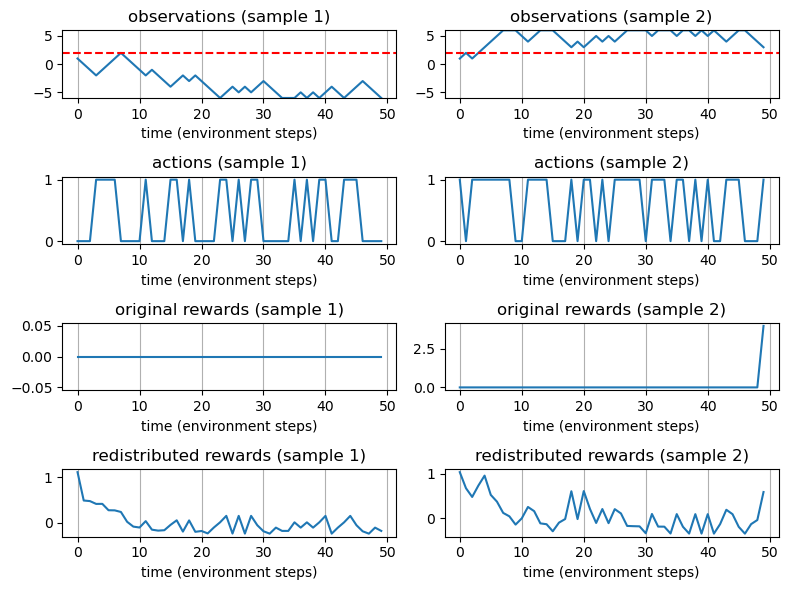

In [31]:
# Let's plot our samples with the redistributed rewards:
redistributed_reward = redistributed_reward.cpu().detach().numpy()
rr0, rr1 = redistributed_reward[0], redistributed_reward[1]

fig, axes = plt.subplots(4, 2, figsize=(8, 6), dpi=100)
axes[0, 0].plot(obs0.argmax(-1) - 6)
axes[0, 1].plot(obs1.argmax(-1) - 6)
axes[0, 0].set_ylim(-6, 6)
axes[0, 1].set_ylim(-6, 6)
axes[0, 0].axhline(2, linestyle='--', color='r')
axes[0, 1].axhline(2, linestyle='--', color='r')
axes[0, 0].xaxis.grid(True)
axes[0, 1].xaxis.grid(True)
axes[0, 0].set_title('observations (sample 1)')
axes[0, 1].set_title('observations (sample 2)')
axes[0, 0].set_xlabel('time (environment steps)')
axes[0, 1].set_xlabel('time (environment steps)')

axes[1, 0].plot(a0.argmax(-1))
axes[1, 1].plot(a1.argmax(-1))
axes[1, 0].xaxis.grid(True)
axes[1, 1].xaxis.grid(True)
axes[1, 0].set_title('actions (sample 1)')
axes[1, 1].set_title('actions (sample 2)')
axes[1, 0].set_xlabel('time (environment steps)')
axes[1, 1].set_xlabel('time (environment steps)')

axes[2, 0].plot(r0)
axes[2, 1].plot(r1)
axes[2, 0].xaxis.grid(True)
axes[2, 1].xaxis.grid(True)
axes[2, 0].set_title('original rewards (sample 1)')
axes[2, 1].set_title('original rewards (sample 2)')
axes[2, 0].set_xlabel('time (environment steps)')
axes[2, 1].set_xlabel('time (environment steps)')

axes[3, 0].plot(rr0)
axes[3, 1].plot(rr1)
axes[3, 0].xaxis.grid(True)
axes[3, 1].xaxis.grid(True)
axes[3, 0].set_title('redistributed rewards (sample 1)')
axes[3, 1].set_title('redistributed rewards (sample 2)')
axes[3, 0].set_xlabel('time (environment steps)')
axes[3, 1].set_xlabel('time (environment steps)')

fig.tight_layout()